# Potts

In [ ]:
import time

import numpy as np
from matplotlib import pyplot as plt

from IPython.display import clear_output


%matplotlib inline


class potts:
	def __init__(self, L,q):	#Create Potts model
	
		self.L=L		#lattice length/width
		self.size=L**2	#model size
		self.q=q		#number of states
		self.h=np.zeros(self.q)		#bias
		self.J=1	#couplings
		self.randomize_state()
	
		self.set_temp()
		
	def set_temp(self,T=1):
		self.T=1.0
		self.beta=1.0/self.T
	def set_beta(self,B):
		self.beta=B
		if B==0:
			self.B=None
		else:
			self.T=1/B

	def randomize_state(self):
		self.s = np.random.randint(0,self.q,(self.L,self.L))

	def MetropolisStep(self):	    #Execute step of Metropolis algorithm
		i = np.random.randint(self.L)		#row
		j = np.random.randint(self.L)		#column
		snew = np.random.randint(self.q)	#target state
		
		eDiff = self.h[self.s[i,j]]-self.h[snew]
		eDiff+= self.J*(int(self.s[i,j]==self.s[(i+1)%self.L,j])-int(snew==self.s[(i+1)%self.L,j]))	#up
		eDiff+= self.J*(int(self.s[i,j]==self.s[(i-1)%self.L,j])-int(snew==self.s[(i-1)%self.L,j]))	#down
		eDiff+= self.J*(int(self.s[i,j]==self.s[i,(j+1)%self.L])-int(snew==self.s[i,(j+1)%self.L]))	#right
		eDiff+= self.J*(int(self.s[i,j]==self.s[i,(j-1)%self.L])-int(snew==self.s[i,(j-1)%self.L]))	#left
		if eDiff <= 0 or np.random.rand() < np.exp(-self.beta*eDiff):    # Metropolis!
			self.s[i,j] = snew
			
	def Energy(self):
		E=0
		for i in range(self.L):
			for j in range(self.L):
				E-= self.h[self.s[i,j]]
				E-= self.J*int(self.s[i,j]==self.s[(i+1)%self.L,j])	#up
				E-= self.J*int(self.s[i,j]==self.s[(i-1)%self.L,j])	#down
				E-= self.J*int(self.s[i,j]==self.s[i,(j+1)%self.L])	#right
				E-= self.J*int(self.s[i,j]==self.s[i,(j-1)%self.L])	#left
		return(E)

[[1 1 1 0 1]
 [0 2 1 2 0]
 [2 0 0 1 1]
 [2 2 0 0 1]
 [2 1 1 0 2]]


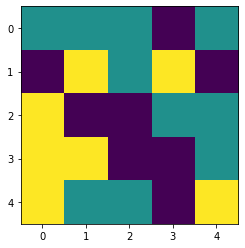

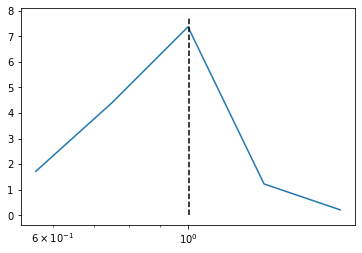

In [ ]:
L=5
q=3
size=L**2

P=potts(L,q)

print(P.s)


fig = plt.figure()
im = plt.imshow(P.s)

viz = [np.array(P.s)]

Nbetas=5#21
betas=10**np.linspace(-0.25,0.25,Nbetas)
C=np.zeros(Nbetas)

for bind in range(Nbetas):
	P.set_beta(betas[bind])
	T=10000
	E=np.zeros(T)
	for t in range(T):
		for rep in range(L**2):
			P.MetropolisStep()
		E[t]=P.Energy()
		viz += [np.array(P.s)]

	C[bind]=betas[bind]*np.var(E)/size

Bc=np.log(1+np.sqrt(q))


plt.figure()
plt.semilogx(betas,C)
plt.semilogx([Bc,Bc],[0,np.max(C)*1.05],'--k')
plt.show()

In [ ]:
print(len(viz), viz[0].shape)

fig = plt.figure()
im = plt.imshow(viz[0])
# plt.show()

def show(im, fig, array):
    for s in array:
        im.set_data(s)
        fig.canvas.flush_events()
        # time.sleep(0.03)
        # clear_output(wait=True)

show(im, fig, viz)

# CPM

In [ ]:
import numpy as np
from skimage import measure

class CPM:
	def __init__(self, L,cells=[1],V0=None,th=1):	#Create Potts model
	
		self.L=L		#lattice length/width
		self.size=L**2	#model size
		self.cells=cells
		self.c=1+np.sum(self.cells)
		self.q=1+len(self.cells)		#number of states
		self.J=np.zeros((self.q,self.q))	#couplings
		self.th = th	# volume constraint
		self.type = [0]
		i=0
		for c in self.cells:
			i+=1
			for rep in range(c):
				self.type+=[i]
				
		if V0 is None:
			self.V0=int(np.round(L*L/(self.c-1)*0.5))
		else:
			self.V0=V0
			
		self.randomize_couplings()
		self.initialize_state()
		self.set_temp()
		
		
	def set_temp(self,T=1):
		self.T=1.0
		self.beta=1.0/self.T
		
		
	def set_beta(self,B):
		self.beta=B
		if B==0:
			self.B=None
		else:
			self.T=1/B
	
	
	def randomize_couplings(self):
		for i in range(self.q):
			for j in range(i,self.q):
				self.J[i,j]=np.random.rand()
				if not i==j:
					self.J[j,i]=self.J[i,j]
		self.J[0,0]=0
		
			
	def initialize_state(self):
#		self.s = np.random.randint(0,self.c,(self.L,self.L))
		self.s=np.zeros((self.L,self.L),int)	#add starting cells in random positions
		for ind in range(1,self.c):
			i,j = np.random.randint(1,self.L-1,2)	# row,column of cell, borders are forbidden
			self.s[i,j]=ind
		self.VE = self.volume_energy(self.s)


	def volume_energy(self,s):
		unique, counts = np.unique(s, return_counts=True)
		V=counts[1:]
		return self.th/(2*self.V0)*np.sum((V-self.V0)**2)
		
		#old code computing areas of connected blobs
#		cells= measure.label(s,connectivity=1)
#		props=measure.regionprops(cells)
#		print('areas',[prop.filled_area for prop in props])
#		return np.sum([(prop.filled_area-self.V0)**2 for prop in props])


	def get_neighbors(self,i,j):	# Get the array of Von Newmann neighbors of a cell
		nn = []
		nn+=[self.s[(i+1)%self.L,j]]	#up
		nn+=[self.s[(i-1)%self.L,j]]	#down
		nn+=[self.s[i,(j-1)%self.L]]	#left
		nn+=[self.s[i,(j+1)%self.L]]	#right

		return np.array(nn)
			
			
	def get_moore_neighbors(self,i,j):	# Get the array of Moore neighbors of a cell
		nn = []
		nn+=[self.s[(i+1)%self.L,(j-1)%self.L]]	#up-left
		nn+=[self.s[(i+1)%self.L,j]]			#up
		nn+=[self.s[(i+1)%self.L,(j+1)%self.L]]	#up-right
		nn+=[self.s[i,(j+1)%self.L]]			#right
		nn+=[self.s[(i-1)%self.L,(j+1)%self.L]]	#down-right
		nn+=[self.s[(i-1)%self.L,j]]			#down
		nn+=[self.s[(i-1)%self.L,(j-1)%self.L]]	#down-left
		nn+=[self.s[i,(j-1)%self.L]]			#left
		return np.array(nn)	
		
		
	def is_locally_connected(self,cell_domain): # Detect local connectivity
		# cell_domain should be 1 if cell is present and 0 otherwise
		transitions=0
		is_connected=False
		if np.sum(cell_domain)>0:
			for i in range(8):
				if cell_domain[i]<cell_domain[(i+1)%8]:	# +1 if transition from 0 to 1
					transitions+=1
			if transitions<=1:
				is_connected=True
		return is_connected



	def MetropolisStep(self,mode='CA'):	    # Execute step of Metropolis algorithm
		
		#Select candidate and target nodes	
		if mode=='MMA':
			i,j = np.random.randint(1,self.L-1,2)	# row,column of cell, borders are forbidden
			nn=self.get_neighbors(i,j)				# array of cell neighbors 
			sijnew = nn[np.random.randint(len(nn))]		# target state
			cond = sijnew!=self.s[i,j]
			
		if mode=='CA':
			i,j = np.random.randint(1,self.L-1,2)	# row,column of cell
			nn=self.get_neighbors(i,j)				# array of cell neighbors 
			nn_unique=np.unique(nn)
			sijnew = nn_unique[np.random.randint(len(nn_unique))]		# target state
			domain=self.get_moore_neighbors(i,j)
			lc_candidate=self.is_locally_connected(domain==self.s[i,j])
			lc_target=self.is_locally_connected(domain==sijnew)
			cond = lc_candidate and lc_target and sijnew!=self.s[i,j]

			
		#Evaluate acceptance of change
		if cond:
			eDiff = 0
			
			coupling_neighbors=self.get_neighbors(i,j)
			#Compute adhesion energy difference
			for sn in coupling_neighbors:
				eDiff+= self.J[self.type[sijnew],self.type[sn]]*int(sijnew!=sn) - self.J[self.type[self.s[i,j]],self.type[sn]]*int(self.s[i,j]!=sn) 
			#Compute volume energy difference
			snew=self.s.copy()
			snew[i,j] = sijnew
			VEnew = self.volume_energy(snew)
			eDiff += VEnew - self.VE
			if eDiff <= 0 or np.log(np.random.rand()) < -self.beta*eDiff:    # Metropolis
				self.s[i,j] = sijnew
				self.VE = VEnew
				

	def Energy(self):
		E=self.volume_energy(self.s)
		for i in range(self.L):
			for j in range(self.L):
				if self.s[i,j]>0:
					coupling_neighbors=self.get_neighbors(i,j)
					#Compute adhesion energy difference
					for sn in coupling_neighbors:
						if sn<self.s[i,j]:	#we compute each link just once
							E+= self.J[self.type[self.s[i,j]],self.type[sn]]*int(self.s[i,j]!=sn)
		return(E)

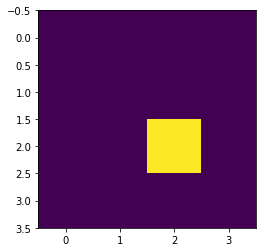

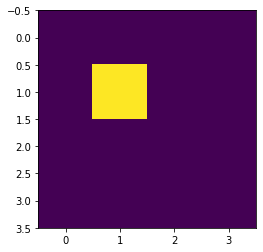

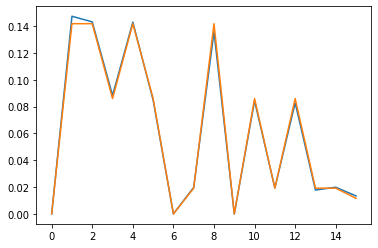

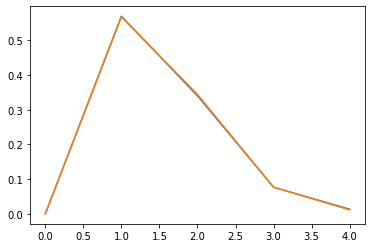

In [ ]:
#Transform bool array into positive integer
def bool2int(x):				
    y = 0
    for i,j in enumerate(np.array(x)[::-1]):
        y += j*2**i
    return int(y)
    
#Transform positive integer into bit array
def bitfield(n,size):	
    x = [int(x) for x in bin(int(n))[2:]]
    x = [0]*(size-len(x)) + x
    return np.array(x)
    
      
L=4
size=L**2
V0=3

cells=[1]

C=CPM(L,cells=cells,V0=V0)

C.J=np.array([[0,1],[1,0]])*1
C.th=3

T=10000
T0=int(T/10)

import timeit
start_time = timeit.default_timer()


P=np.zeros(2**((L-2)**2))
K=np.zeros(1+(L-2)**2)


allowed=set()
C.initialize_state()


plt.figure()
plt.imshow(C.s)

for t in range(T0):
		for rep in range(1+(L-2)**2):
			C.MetropolisStep(mode='CA')
for t in range(T):
		for rep in range(1+(L-2)**2):
			C.MetropolisStep(mode='CA')
		ind=bool2int(C.s[1:-1,1:-1].flatten())
		allowed.add(ind)
#		print()
#		print(C.s[1:-1,1:-1])
#		print(bitfield(ind,(L-2)**2).reshape((L-2,L-2)))
		P[ind]+=1
		K[np.sum(C.s[1:-1,1:-1])]+=1
		
P/=np.sum(P)

# code you want to evaluate
elapsed = timeit.default_timer() - start_time
K/=np.sum(K)

plt.figure()
plt.imshow(C.s)

a=np.array([[0,1],[1,0]])
# print(a.flatten())
# print(bool2int(a.flatten()))
		
# print(C.J)

P1=np.zeros(2**((L-2)**2))
K1=np.zeros(1+(L-2)**2)
#forbidden=[0,6,9]
for n in range(2**((L-2)**2)):
#	if not n in forbidden:
	if n in allowed:
		C.s[1:-1,1:-1]=bitfield(n,(L-2)**2).reshape((L-2,L-2))
		# print(n)
		# print(bitfield(n,(L-2)**2).reshape((L-2,L-2)))
		E=C.Energy()
		P1[n]=np.exp(-E)
		K1[np.sum(C.s[1:-1,1:-1])]+=np.exp(-E)

P1/=np.sum(P1)
K1/=np.sum(K1)


plt.figure()
plt.plot(P)
plt.plot(P1)
plt.figure()
plt.plot(K)
plt.plot(K1)

plt.show()